In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import gmean

In [3]:
import sys; sys.path.insert(0, '../')
from gp_inspection import extract_metric_evolution
from gp_experiments import rescale_linear

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
paths = [
    ('Venture'           , '../resources/reports/stamp@20181102-155157_shortname@vs-euHdZTNmNT_ntest@20_iters@5_epochs@200_schedule@constant_seed@1387012777.merged.report.csv'),
    ('Gen (naive)'       , '../resources/reports/stamp@20181102-174139_shortname@lightweight-Mzc0ZW_ntest@20_iters@5_epochs@400_schedule@constant_seed@945467991.merged.report.csv'),
    ('Gen (incremental)' , '../resources/reports/stamp@20181104-141136_shortname@incremental-iOpZa_ntest@20_iters@5_epochs@400_schedule@constant_seed@4027282976.merged.report.csv'),
    ('Handcoded (naive)' , '../resources/reports/stamp@20181104-143323_shortname@handcoded-iZaMk_ntest@20_iters@5_epochs@400_schedule@constant_seed@1788702245.merged.report.csv'),
]

In [5]:
def plot_evolution_one(runtimes, metrics, label, color, ax):
    runtimes = runtimes[1:]
    metrics = metrics[1:]
    #  Some filtering.
    # keep = np.argsort(metrics[-1,:])[:-10]
    # metrics = metrics[:, keep]
    # runtimes = runtimes[:,keep]
    #  Computing metrics to plot.
    x_runtime = np.cumsum(np.median(runtimes, axis=1))
    y_metric_median = np.mean(metrics, axis=1)
    y_metric_high = np.percentile(metrics, 75, axis=1)
    y_metric_low = np.percentile(metrics, 25, axis=1)
    # Plot.
    ax.errorbar(x_runtime[::10], y_metric_median[::10],
        # yerr=[y_metric_median-y_metric_low, y_metric_high-y_metric_median],
        fmt='--.', 
        label=label, color=color)
    return ax

In [6]:
metric = 'rmse'

In [7]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'sans-serif'

Plot runtime vs. accuracy

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


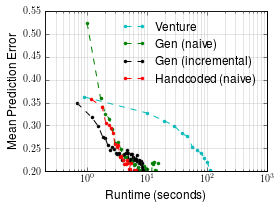

In [8]:
fig, ax = plt.subplots()
colors = ['c', 'g', 'k', 'r']
for i, (method, path) in enumerate(paths):
    runtimes, metrics = extract_metric_evolution(path, 'runtime', metric)
    ax = plot_evolution_one(runtimes, metrics, method, colors[i], ax)

# ax.set_title('Runtime vs. Accuracy on Airline Data', fontsize=13)
ax.set_ylabel('Mean Prediction Error', fontsize=12)
ax.set_xlabel('Runtime (seconds)', fontsize=12)
ax.legend(loc='upper right', framealpha=0)
ax.grid(which='both', linestyle='-', linewidth=1, color='gray', alpha=.2)
ax.set_xscale('log')
ax.set_xlim([2*10**-1, 10**3])
ax.set_ylim([0.2, None])
fig.set_facecolor('white')
fig.set_tight_layout(True)
fig.set_size_inches(4, 3)

In [9]:
fig.savefig('airline-gen-venturescript-runtime-rmse.pdf')

Plot observed and forecasted data

In [10]:
import json
from gp_experiments import rescale_linear
from gp_experiments import unscale_linear

In [11]:
fname = '../resources/results/stamp@20181102-155414_shortname@vs-euHdMzVkOW_ntest@20_iters@5_epochs@200_schedule@constant_seed@725158738.json'
with open(fname, 'r') as f:
    results = json.load(f)

In [12]:
predictions = results['statistics'][-1]['predictions_held_out']

In [13]:
(x_min, y_min) = (1.949041666666666742e+03, 1.12e+02)
(x_max, y_max) = (1.960958333333333258e+03,4.32e+02)

In [14]:
xs_train = unscale_linear(np.array(results['xs_train']), 0, 1, x_min, x_max)
ys_train = unscale_linear(np.array(results['ys_train']), -1, 1, y_min, y_max)
xs_test = unscale_linear(np.array(results['xs_test']), 0, 1, x_min, x_max)
ys_test = unscale_linear(np.array(results['ys_test']), -1, 1, y_min, y_max)
predictions = unscale_linear(np.array(predictions), -1, 1, y_min, y_max)

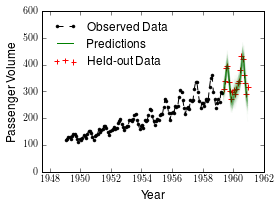

In [15]:
fig, ax = plt.subplots()
ax.plot(xs_train, ys_train, marker='.', linestyle='--', color='k', label='Observed Data')
for p in predictions:
    ax.plot(xs_test, p, linestyle='-', color='g', alpha=.025)
ax.plot([], [], color='g', label='Predictions')
ax.scatter(xs_test, ys_test, marker='+', color='r', s=30, label='Held-out Data')
ax.legend(framealpha=0, loc='upper left')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Passenger Volume', fontsize=12)
# ax.set_title('Airline Dataset', fontsize=13)
ax.set_xlim([1947.5, None])
fig.set_tight_layout(True)
fig.set_size_inches(4, 3)

In [16]:
fig.savefig('airline-raw-data.pdf')

In [17]:
def report_runtime(runtimes, method):
    runtimes = runtimes[1:]
    runtimes_total = np.cumsum(runtimes, axis=0)
    median = np.median(runtimes_total, axis=1)[-1]
    upper = np.percentile(runtimes_total, 25, axis=1)[-1]
    lower = np.percentile(runtimes_total, 75, axis=1)[-1]
    error = np.mean([abs(median-upper), abs(median-lower)])
    with open('gp-runtime', 'a') as f:
        print>>f, '%s: %1.2f (+- %1.2f)' % (method, median/2, error/2)

In [18]:
!rm -f gp-runtime && touch gp-runtime
for method, path in paths:
    runtimes, metrics = extract_metric_evolution(path, 'runtime', metric)
    report_runtime(runtimes, method)

In [19]:
!rm -f gp-loc && touch gp-loc
!wc -l ../resources/gp_model_0.vnts >> gp-loc
!wc -l ../lightweight.jl >> gp-loc
!wc -l ../incremental.jl >> gp-loc
!wc -l ../handcoded.jl >> gp-loc